<a href="https://colab.research.google.com/github/akhraishasnaeencg-design/The-Enron-Email-Dataset/blob/main/The_Enron_Email_Dataset_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ===============================
# ENRON EMAIL ANALYSIS - DBSCAN
# ===============================
Mounted at /content/drive
Dataset extrait avec succès ✅
Taille dataset : 517401
Taille échantillon : 50000
TF-IDF en cours...
Calcul K-distance...


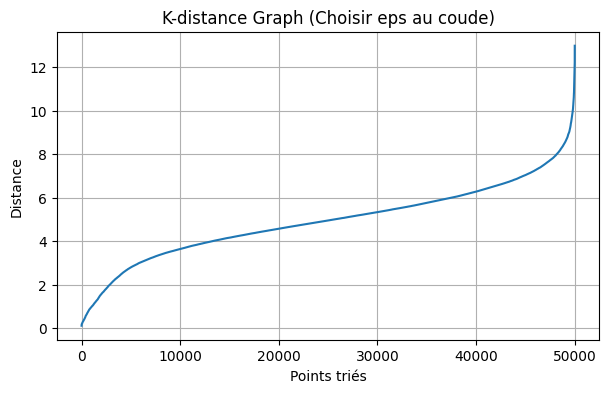

DBSCAN clustering...
Clusters détectés : 38
Visualisation PCA...


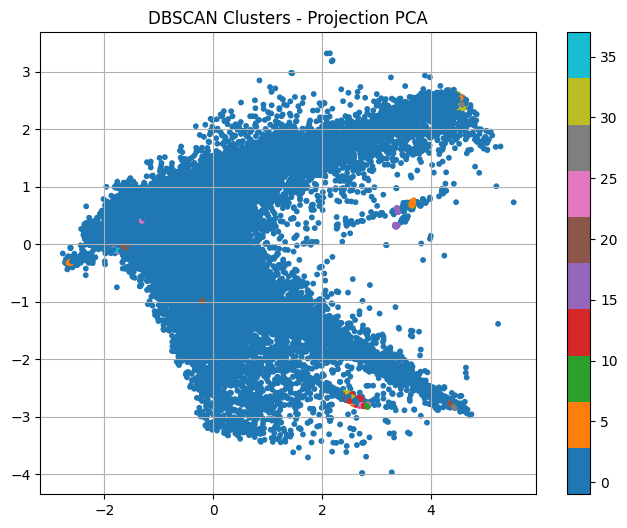

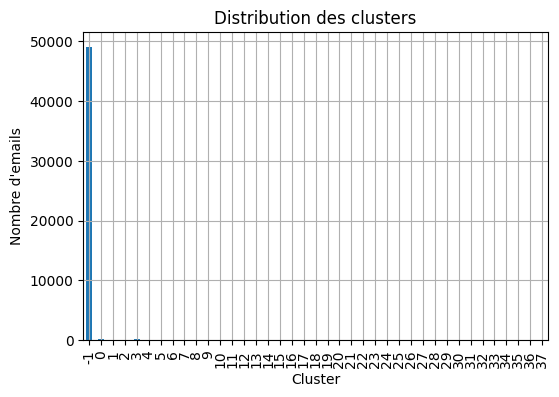

Matrice de confusion...


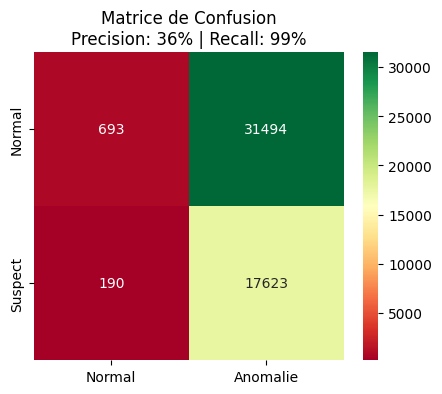


# ===============================
# RESULTATS FINAUX
# ===============================
Total emails : 50000
Emails suspects réels : 17813
Emails détectés anomalies : 49117
Precision : 35.88%
Recall : 98.93%


In [1]:
# =====================================================
# INSTALLATION DES BIBLIOTHEQUES
# =====================================================
!pip install pandas numpy scikit-learn matplotlib seaborn

# =====================================================
# IMPORTS
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix

print("\n# ===============================")
print("# ENRON EMAIL ANALYSIS - DBSCAN")
print("# ===============================")

# =====================================================
# MONTER GOOGLE DRIVE
# =====================================================
drive.mount('/content/drive')

# =====================================================
# CHARGER ET EXTRAIRE LE ZIP
# =====================================================
zip_path = "/content/drive/MyDrive/emails.csv.zip"
extract_path = "/content/drive/MyDrive/enron_extract"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extrait avec succès ✅")

# Trouver le fichier CSV
csv_file = [f for f in os.listdir(extract_path) if f.endswith(".csv")][0]

df = pd.read_csv(os.path.join(extract_path, csv_file))

# =====================================================
# ÉCHANTILLON REPRESENTATIF
# =====================================================
df = df.dropna(subset=["message"])

df_sample = df.sample(n=50000, random_state=42)

print("Taille dataset :", len(df))
print("Taille échantillon :", len(df_sample))

# =====================================================
# CREATION LABEL ACADEMIQUE (SIMULATION SPAM)
# =====================================================
keywords = ["free", "money", "offer", "win", "cash", "urgent"]

def label_email(text):
    text = text.lower()
    return 1 if any(word in text for word in keywords) else 0

df_sample["Vrai_Label"] = df_sample["message"].apply(label_email)

# =====================================================
# TF-IDF VECTORISATION
# =====================================================
print("TF-IDF en cours...")

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=3000
)

X = vectorizer.fit_transform(df_sample["message"])

# =====================================================
# REDUCTION DIMENSION
# =====================================================
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

# =====================================================
# STANDARDISATION
# =====================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# =====================================================
# GRAPHIQUE K-DISTANCE (CHOIX EPS)
# =====================================================
print("Calcul K-distance...")

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)

distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 9])

plt.figure(figsize=(7,4))
plt.plot(distances)
plt.title("K-distance Graph (Choisir eps au coude)")
plt.xlabel("Points triés")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# =====================================================
# DBSCAN CLUSTERING
# =====================================================
print("DBSCAN clustering...")

model = DBSCAN(eps=0.8, min_samples=10)
labels = model.fit_predict(X_scaled)

df_sample["Cluster"] = labels
df_sample["Anomalie"] = labels == -1

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("Clusters détectés :", n_clusters)

# =====================================================
# VISUALISATION PCA 2D
# =====================================================
print("Visualisation PCA...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=labels,
    cmap="tab10",
    s=10
)

plt.title("DBSCAN Clusters - Projection PCA")
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# =====================================================
# DISTRIBUTION DES CLUSTERS
# =====================================================
plt.figure(figsize=(6,4))
df_sample["Cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'emails")
plt.grid(True)
plt.show()

# =====================================================
# MATRICE DE CONFUSION
# =====================================================
print("Matrice de confusion...")

y_true = df_sample["Vrai_Label"]
y_pred = df_sample["Anomalie"].astype(int)

cm = confusion_matrix(y_true, y_pred)

tp = cm[1,1]
fp = cm[0,1]
tn = cm[0,0]
fn = cm[1,0]

precision = tp/(tp+fp) if (tp+fp)>0 else 0
recall = tp/(tp+fn) if (tp+fn)>0 else 0

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="RdYlGn",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Suspect"])

plt.title(f"Matrice de Confusion\nPrecision: {precision:.0%} | Recall: {recall:.0%}")
plt.show()

# =====================================================
# RESULTATS FINAUX
# =====================================================
print("\n# ===============================")
print("# RESULTATS FINAUX")
print("# ===============================")

print("Total emails :", len(df_sample))
print("Emails suspects réels :", y_true.sum())
print("Emails détectés anomalies :", df_sample["Anomalie"].sum())
print("Precision :", f"{precision:.2%}")
print("Recall :", f"{recall:.2%}")